## Task Formulation
The goal is to perform demand forecasting for each product category.<br><br>
Notes:
* Demand is assumed to be synonymous with the value of things,
* Expected forecasting horizon is around 14 days,
* Weekly seasonality is reportedly alleged (according to `Data Card` description).

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Environment
import numpy as np
import pandas as pd
import sqlalchemy
import sklearn
import sktime
print('Numpy:      {}'.format(np.__version__))
print('Pandas:     {}'.format(pd.__version__))
print('SQLAlchemy: {}'.format(sqlalchemy.__version__))
print('Sklearn:    {}'.format(sklearn.__version__))
print('Sktime:     {}'.format(sktime.__version__))

Numpy:      1.21.6
Pandas:     1.5.3
SQLAlchemy: 1.4.46
Sklearn:    1.3.2
Sktime:     0.29.1


# Transactional Data

`Data Quality`<br>
Careful review of `Data Card` and `Data Explorer` associated with `transactional_data.sqlite` reveals two minor issues with this data:
* `orders.timestamp` is VARCHAR
* Couple of missing values for `products.product_weight_g`

`SQL Alchemy`<br>
SQLAlchemy is a Python library that allows you to leverage DBMS efficiency and interact with databases conveniently from within your notebook. It supports multiple Database Management Systems (DBMSs), including SQLite, PostgreSQL, MySQL, and Oracle.

In [2]:
from sqlalchemy import create_engine, inspect, text

# Create a database engine
engine = create_engine('sqlite:////home/petewojtczak/databases/transactional_data.sqlite')
# simplified schema and tables info
with engine.connect() as conn:
    inspector = inspect(engine)    
    for table_name in inspector.get_table_names():
        # Retrieve column information
        columns_info = inspector.get_columns(table_name)
        columns = [col['name'] for col in columns_info]        
        # Check for primary key
        primary_key = next((col['name'] for col in columns_info if col['primary_key']), None)        
        # Check for foreign keys
        foreign_keys_info = inspector.get_foreign_keys(table_name)
        foreign_key_columns = [fk['constrained_columns'][0] for fk in foreign_keys_info]        
        # Count the number of records in the table
        num_records_query = text(f"SELECT COUNT(*) FROM '{table_name}'")
        num_records = conn.execute(num_records_query).scalar()        
        # Print results
        print(f"\n\033[1m'{table_name}'\033[0m")
        print(f"Number of Records: {num_records}")
        print(f"Columns: {columns}")
        print(f"Primary Key: {primary_key}")
        if foreign_key_columns:
            print("Foreign Key Column(s):")
            for fk_column in foreign_key_columns:
                print(f"  - {fk_column}")
        else:
            print("Foreign Key: None")


'order_items'
Number of Records: 110197
Columns: ['order_items_pk', 'order_id', 'product_id', 'seller_id', 'price']
Primary Key: order_items_pk
Foreign Key Column(s):
  - order_id
  - product_id
  - seller_id

'order_reviews'
Number of Records: 39462
Columns: ['review_id', 'order_id', 'review_score', 'review_comment_message']
Primary Key: review_id
Foreign Key Column(s):
  - order_id

'orders'
Number of Records: 96478
Columns: ['order_id', 'timestamp', 'customer_contact']
Primary Key: order_id
Foreign Key: None

'products'
Number of Records: 32216
Columns: ['product_id', 'product_category_name', 'product_weight_g']
Primary Key: product_id
Foreign Key: None

'sellers'
Number of Records: 2970
Columns: ['seller_id', 'seller_state']
Primary Key: seller_id
Foreign Key: None


## Relevant Tables
Three tables: `orders`, `order_items`, and `products` are necessary to do the task of forecasting demand.

`orders`<br>
Provides details about each order.<br><br>
**Columns description**:
* `order_id`; PK, unique identifier of the order(VARCHAR),<br>
* `timestamp`; shows the purchase timestamp (VARCHAR),<br> 
* `customer_contact`; unique identifier of the consumer (VARCHAR).

In [3]:
orders = """
SELECT order_id,
       timestamp,
       customer_contact
FROM orders
"""
pd.read_sql_query(orders, engine).set_index('order_id').head(3)

,timestamp,customer_contact
order_id,,
e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,9ef432eb6251297304e76186b10a928d
53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,b0830fb4747a6c6d20dea0b8c802d7ef
47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,41ce2a54c0b03bf3443c3d931a367089


`order_items`<br>
Serves as a container for a set of items associated with each order.<br><br>
**Columns description**:
* `order_items_pk`; PK, row unique identifier (INTEGER).<br>
* `order_id`; FK, order unique identifier (VARCHAR).<br>
* `product_id`; FK, product unique identifier (VARCHAR).<br>
* `seller_id`; FK, seller unique identifier (VARCHAR).<br>
* `price`; item price (FLOAT).

In [4]:
order_items = """
SELECT order_items_pk, 
       order_id, 
       product_id, 
       seller_id, 
       price 
FROM order_items
"""
pd.read_sql_query(order_items, engine).set_index('order_items_pk').head(3)

,order_id,product_id,seller_id,price
order_items_pk,,,,
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0


`products`<br>
 Products available on the marketplace.<br><br>
**Columns description**:
* `product_id`; PK, product unique identifier (VARCHAR),<br>
* `product_category_name`; root category of product, in Portuguese (VARCHAR),<br>
* `product_weight_g`; product weight measured in grams (FLOAT).

In [5]:
products = """
SELECT product_id, 
       product_category_name, 
       product_weight_g
FROM products
"""
pd.read_sql_query(products, engine).set_index('product_id').head(3)

,product_category_name,product_weight_g
product_id,,
1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0
3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0
96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0


## Data Landscape

In [6]:
def ts_cleaning(ts):
    # data cleaning procedures used across this notebook for query results
    ts['order_date'] = pd.to_datetime(ts['order_date'])
    ts.set_index('order_date', inplace=True)
    full_index = pd.date_range(start=ts.index.min(), end=ts.index.max(), freq='D')
    ts = ts.reindex(full_index, fill_value=0)
    ts.index.name = 'order_date'
    return ts

In [7]:
distinct_categories = """
SELECT COUNT(DISTINCT product_category_name) AS distinct_category_count
FROM products
"""
pd.read_sql_query(distinct_categories, engine)

,distinct_category_count
0,74


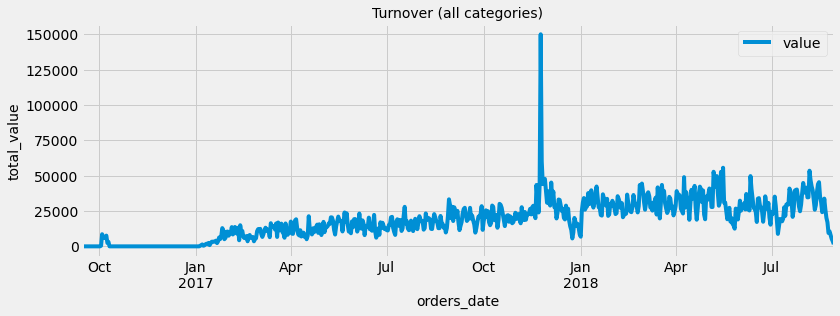

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

 # order_date is a VARCHAR, but in SQLite it behaves as a date for ordering and grouping
all_categories_turnover = f"""
        SELECT
            date(o.timestamp) AS order_date,
            SUM(oi.price) AS value
        FROM orders o 
        JOIN order_items oi ON o.order_id = oi.order_id
        JOIN products p ON oi.product_id = p.product_id
        GROUP BY date(o.timestamp)
        ORDER BY order_date
    """
# data retrival and cleaning
marketplace_turnover = pd.read_sql_query(all_categories_turnover, engine)
marketplace_turnover = ts_cleaning(marketplace_turnover)
# plotting
ax = marketplace_turnover.plot(figsize=(12, 4))
ax.set_title('Turnover (all categories)', fontsize=14)
ax.set_xlabel('orders_date', fontsize=14)
ax.set_ylabel('total_value', fontsize=14)
plt.show()

Our marketplace data reveals three apparent issues:
* `Sparse data` linked to the initial stages of activity,
*  An `outlier` with a total value reaching as high as 150k,
* A `sudden drop in turnover` in the last few days.<br>

Each of these issues could significantly impact the predictive accuracy of our forecasting models.

`Sparse Data`<br>
To mitigate issues with sparse data, we will set 2017-02-01 as the starting date for learning algorithms.

In [9]:
marketplace_turnover = marketplace_turnover['2017-02-01':]

`Outlier`<br>
A single outlier data point will be replaced, for some categories, with the mean of its two nearest data points.

In [10]:
marketplace_turnover = marketplace_turnover.copy()
if marketplace_turnover.loc['2017-11-24', "value"] == marketplace_turnover["value"].max():
    new_value = (marketplace_turnover.loc['2017-11-23', 'value'] + 
                 marketplace_turnover.loc['2017-11-25', 'value']) / 2
    marketplace_turnover.loc['2017-11-24', 'value'] = new_value

`Sudden Drop in Turnover`<br>
This issue is also somewhat related to sparse data at the end of the time series. Since we expect a forecasting horizon of 14 days, we will exclude the 7 most recent (and potentially suspicious) data points from our datasets, while extending our forecasting horizon to 21 days. It’s important to note that sklearn algos learn patterns from historical data to make predictions. If a sudden shock event occurs, the model is not a magic solution and will likely be unable to account for it accurately. Here, we are essentially assuming that no shock event has occurred and are disregarding the latest few data points to presumably avoid skewing the predictions.

In [11]:
marketplace_turnover = marketplace_turnover.loc[:'2018-08-22']

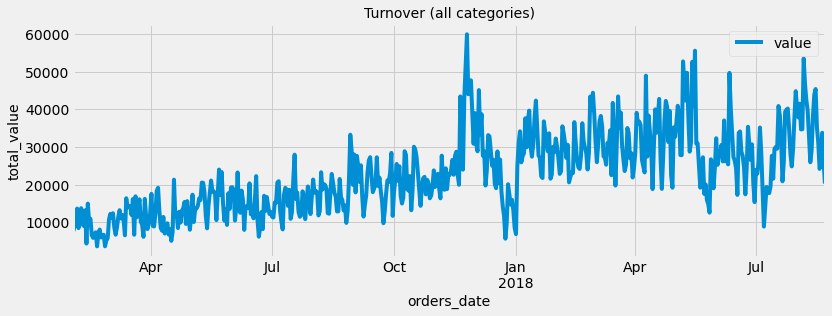

In [12]:
# Aggregated actual training data will closly resemble this
ax = marketplace_turnover.plot(figsize=(12, 4))
ax.set_title('Turnover (all categories)', fontsize=14)
ax.set_xlabel('orders_date', fontsize=14)
ax.set_ylabel('total_value', fontsize=14)
plt.show()

## Outlook on Product Categories

In [13]:
query = """
SELECT p.product_category_name, 
       SUM(oi.price) AS value, 
       COUNT(oi.order_items_pk) AS items_qty
FROM products p 
JOIN order_items oi ON p.product_id = oi.product_id
GROUP BY p.product_category_name
ORDER BY value DESC
"""
categories_summary = pd.read_sql_query(query, engine)
categories_summary.set_index('product_category_name', inplace=True)

### Most valuable categories

In [14]:
categories_summary.head(15)

,value,items_qty
product_category_name,,
beleza_saude,1233131.72,9465
relogios_presentes,1166176.98,5859
cama_mesa_banho,1023434.76,10953
esporte_lazer,954852.55,8431
informatica_acessorios,888724.61,7644
moveis_decoracao,711927.69,8160
utilidades_domesticas,615628.69,6795
cool_stuff,610204.10,3718
automotivo,578966.65,4140


### Least valuable categories

In [15]:
categories_summary.tail(15)

,value,items_qty
product_category_name,,
artigos_de_festas,4465.19,42
livros_importados,4418.86,57
moveis_colchao_e_estofado,4323.38,37
portateis_cozinha_e_preparadores_de_alimentos,3933.63,14
fashion_roupa_feminina,2634.94,45
fashion_esporte,2094.52,29
la_cuisine,2054.99,14
artes_e_artesanato,1814.01,24
fraldas_higiene,1500.79,37


### Sparsity and Modeling
From the `categories_summary.tail(15)` dataframe shown above, it's evident that not all product categories will make it to the modeling phase. There is virtually no market for some categories and a very, very rough rule is 10-20 sample points for an estimated parameter. Given data sparsity, we are forced to limit our analysis, so focusing on the 10 most valuable categories makes sense—especially as there’s still plenty to compute anyway.

# ML (sklearn with sktime)
One thing about time-series forecasting is that it can be reframed to a regression problem through the process of `data tabulation`. Here, we leverage sktime toolkit and for every category we employ a forecasting gridsearch tool in order to find the best set of parameters for two sklearn regressors: `GradientBoostingRegressor` and `RandomForestRegressor`. When these are found, we compare both models' forcasting performance; the better one for a given category is then again refitted with whole data (`y_test` included) and saved into the dictionary models so that it is ready to make future forecasts.<br><br>
The `make_reduction()` function<br>
This function converts time-series data into a tabular format, effectively redefining the forecasting task as a regression problem. A key parameter here is `window_length`, which defines the length of the sliding window used for creating features from the time-series. To achieve the best results, the `window_length` should preferably match the seasonal period of the data, which in this case is reportedly alleged to be 7.<br><br>
`Scalable Design`<br>This solution features a scalable design with a directly tunable number of categories, a workflow that can easily accommodate additional scikit-learn algorithms, and an explicitly defined hyperparameter space for straightforward and easy adjustment.

In [16]:
# here you can change the number of categories
categories_summary = categories_summary.head(10)

In [17]:
# here more regressors can easily be added
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

regressors = {
    'gbr': GradientBoostingRegressor(),
    'RandForest': RandomForestRegressor(criterion='absolute_error'),
}

In [18]:
# here you can easily add, extend or edit hyperparameter grid 
hypergrid = {
    'gbr': {
        "estimator__learning_rate":[0.01, 0.1, 0.5],
        "estimator__warm_start":[True, False]        
    },
    'RandForest': {
        "estimator__n_estimators":[30, 50, 100, 150],
        "estimator__warm_start":[True, False]
    }}

For every category, model space is researched and evaluated using `5-fold cross validation scheme` using `ForecastingGridSearchCV` and `ExpandingWindowSplitter`; best model for a category is refitted with whole data and saved in the `models` dictionary.

In [19]:
%%time
import time
# data tabulation
from sktime.forecasting.compose import make_reduction
# hypertuning
from sktime.forecasting.model_selection import ForecastingGridSearchCV, ExpandingWindowSplitter
# forecst horizon
from sktime.forecasting.base import ForecastingHorizon
# metric
from sktime.performance_metrics.forecasting import MeanAbsoluteError

# container for the best model for a category
models = {}

for category in categories_summary.index:
    print(f'*[sklearn/sktime] Starting training for {category} category...')
    start = time.time()
    
    query = f"""
    SELECT 
        DATE(o.timestamp) AS order_date,
        SUM(oi.price) AS value
    FROM 
        orders o
    JOIN 
        order_items oi ON o.order_id = oi.order_id
    JOIN 
        products p ON oi.product_id = p.product_id
    WHERE 
        p.product_category_name = '{category}' 
        AND DATE(o.timestamp) BETWEEN '2017-02-01' AND '2018-08-22'
    GROUP BY 
        date(o.timestamp)
    ORDER BY 
        order_date
    """
    
    # data retrival and cleaning
    ts = pd.read_sql_query(query, engine)
    ts = ts_cleaning(ts)
    ts = ts.copy()
    if ts.loc['2017-11-24', "value"] == ts["value"].max():
        new_value = (ts.loc['2017-11-23', 'value'] + 
                     ts.loc['2017-11-25', 'value']) / 2
        ts.loc['2017-11-24', 'value'] = new_value
    
    # train/test split 
    y_train = ts.iloc[:len(ts)-21]
    y_test = ts.iloc[len(ts)-21:]
    
    # training
    fit_models = {}
    for algo in regressors.keys():
        regressor = regressors[algo]
        # Since we have weekly seasonality, window_length is 7
        forecaster = make_reduction(regressor, strategy="direct", window_length=7)  
        fh_cv=ForecastingHorizon(np.arange(1, 22))
        # cross-validation using ExpandingWindowSplitter will have 5 steps
        cv = ExpandingWindowSplitter(fh=fh_cv, initial_window=int(len(y_train)-105), step_length=21)  
        fgscv = ForecastingGridSearchCV(forecaster, 
                                        cv=cv, 
                                        param_grid=hypergrid[algo], 
                                        scoring=MeanAbsoluteError())
        fh=ForecastingHorizon(np.arange(1, 22))
        fgscv.fit(y_train, fh=fh)
        fit_models[algo]=fgscv
    
    # Forecasting and evaluating
    best_algo = None
    best_MAE = float('inf')
    best_RMSE = float('inf')

    for algo in regressors.keys():
        y_pred = fit_models[algo].predict(fh)
        algo_MAE = np.mean(np.abs(y_test.values - y_pred.values))
        algo_RMSE = np.sqrt(np.mean((y_pred.values - y_test.values) ** 2)) 
        if algo_MAE < best_MAE:
            best_MAE = algo_MAE
            best_RMSE = algo_RMSE
            best_algo = algo
            
    categories_summary.loc[category, 'best_RMSE'] = best_RMSE
    categories_summary.loc[category, 'best_MAE'] = best_MAE
    
    # Refitting with all data (test sample included)
    y_train = ts
    regressor = regressors[best_algo]
    forecaster = make_reduction(regressor, strategy="direct", window_length=7)
    fh_cv=ForecastingHorizon(np.arange(1, 22))
    cv = ExpandingWindowSplitter(fh=fh_cv, initial_window=int(len(y_train)-105), step_length=21)
    fgscv = ForecastingGridSearchCV(forecaster, 
                                    cv=cv, 
                                    param_grid=hypergrid[best_algo], 
                                    scoring=MeanAbsoluteError())
    
    fh=ForecastingHorizon(np.arange(1, 22))
    fgscv.fit(y_train, fh=fh)
    
    # Saving the best ML model for a category into the dictionary for future use
    models[category] = fgscv
    
    end = time.time()
    elapsed_time_seconds = end - start
    elapsed_time_minutes = elapsed_time_seconds / 60
    print(f' [sklearn/sktime] Best model for {category} fitted. ({elapsed_time_minutes:.2f} min)')

*[sklearn/sktime] Starting training for beleza_saude category...
 [sklearn/sktime] Best model for beleza_saude fitted. (8.23 min)
*[sklearn/sktime] Starting training for relogios_presentes category...
 [sklearn/sktime] Best model for relogios_presentes fitted. (8.12 min)
*[sklearn/sktime] Starting training for cama_mesa_banho category...
 [sklearn/sktime] Best model for cama_mesa_banho fitted. (7.88 min)
*[sklearn/sktime] Starting training for esporte_lazer category...
 [sklearn/sktime] Best model for esporte_lazer fitted. (4.56 min)
*[sklearn/sktime] Starting training for informatica_acessorios category...
 [sklearn/sktime] Best model for informatica_acessorios fitted. (8.68 min)
*[sklearn/sktime] Starting training for moveis_decoracao category...
 [sklearn/sktime] Best model for moveis_decoracao fitted. (4.93 min)
*[sklearn/sktime] Starting training for utilidades_domesticas category...
 [sklearn/sktime] Best model for utilidades_domesticas fitted. (7.68 min)
*[sklearn/sktime] Starti

# Evaluation and Forecasting

`Test sample performance summary`

In [20]:
categories_summary

,value,items_qty,best_RMSE,best_MAE
product_category_name,,,,
beleza_saude,1233131.72,9465,2271.308004,1902.532313
relogios_presentes,1166176.98,5859,1223.617530,980.945060
cama_mesa_banho,1023434.76,10953,992.602633,707.566948
esporte_lazer,954852.55,8431,1598.346766,891.012441
informatica_acessorios,888724.61,7644,831.372611,605.892581
moveis_decoracao,711927.69,8160,649.997991,504.950084
utilidades_domesticas,615628.69,6795,1189.689650,783.057152
cool_stuff,610204.10,3718,557.062484,499.495210
automotivo,578966.65,4140,1457.188686,989.490627


`Forecasting into the Future`<br>
The best ML model for each category is stored in a dedicated dictionary `models`. Models are refitted with the entire dataset after evaluation and will produce forecasts for the next 21 days (the forecasting horizon has already been specified during training).

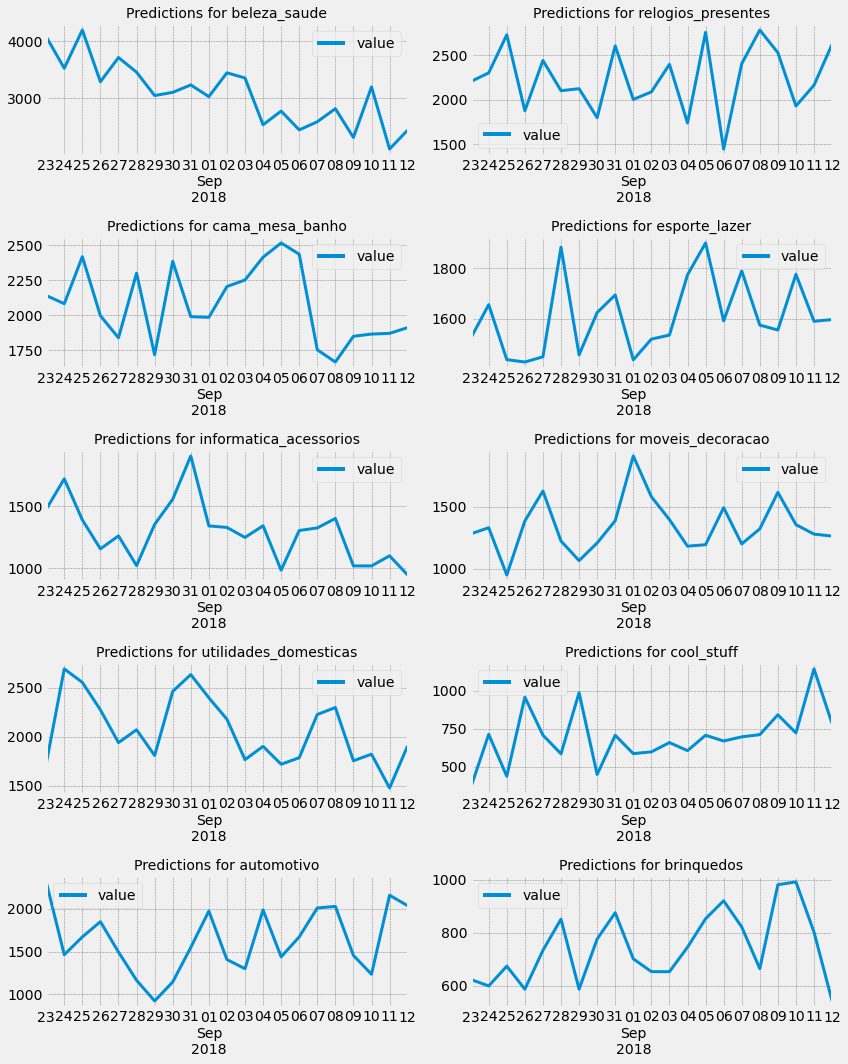

In [21]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Number of categories (or plots)
num_plots = len(categories_summary.index)
cols = 2  
rows = math.ceil(num_plots / cols) 

# Create a figure with the required number of rows and columns
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3))
axes = axes.flatten()

for i, category in enumerate(categories_summary.index):
    ax = axes[i]
    # Generate predictions for each category and plot
    model = models[category]
    forecast = model.predict(fh)
    forecast.plot(ax=ax)
    # Beautify each subplot
    ax.set_title(f'Predictions for {category}', fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    ax.set_xlabel('')
    for line in ax.get_lines():
        line.set_linewidth(3)
        
# Hide any unused subplots if num_plots < rows * cols
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()